In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

58

# set_seed(42)

In [2]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [3]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [9]:
!pip install sklearn

     |████████████████████████████████| 22.3 MB 450 kB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 6.4 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=f6a961536ea9d6dced0ae831f6e7a2049817af3ad0fd319fa95817a7f761302e
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [10]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('preprocess_for_SQUAD_開狀人.csv',index_col=0)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
display(train_df)
display(val_df)

,string_X,Y_label,string_Y_1,string_Y_2
3286,PT STYRO CHEMINDOx000Dx000Dx000DADDRESS SEE FI...,PT STYRO CHEMIND,0,16
2764,HANEL PLASTICS JOINT STOCK COMPANYx000DB15 ROA...,HANEL PLASTICS JOINT STOCK COMPAN,0,33
108,CHAMAN DYESx000DP-97 HABIB MANZIL GALI WAKEELA...,CHAMAN DYE,0,10
1902,INTERNATIONAL PARTNERS LTDx000DLEVEL 2 LOTEMAU...,INTERNATIONAL PARTNERS LTD,0,26
1094,INTERPLAST CO LTDx000DPOBOX4679 SHARJAHUAEx000...,INTERPLAST CO LTD,0,17
...,...,...,...,...
1095,JUMBO HOME DECOCORPORATIONx000D21F-7 NO386 SHI...,JUMBO HOME DECOCORPORATIO,0,25
1130,EL ARABY CO FOR ELECTRICAL ANDx000DELECTRONIC ...,EL ARABY CO FOR ELECTRICAL AN,0,29
1294,POLYONE DISTRIBUTION TRADINGx000DSHANGHAICOLTD...,POLYONE DISTRIBUTION TRADIN,0,27
860,NINGBO EXCITON TECHNOLOGY COLTDx000DNO9 JINGYU...,NINGBO EXCITON TECHNOLOGY COLTD,0,31


,string_X,Y_label,string_Y_1,string_Y_2
414,ZHEJIANG MINGRI HOLDINGS GROUP COx000DLTD NO19...,ZHEJIANG MINGRI HOLDINGS GROUP CO,0,33
314,M K INDUSTRIESx000D710 711 ARUN CHAMBERx000D7T...,M K INDUSTRIE,0,13
2381,R R KABEL LIMITEDx000DSURVEY NO 201-2021202220...,R R KABEL LIMITE,0,16
3236,KIJOO INDUSTRIAL COLTDx000DKIM KI TEAKx000D650...,KIJOO INDUSTRIAL COLT,0,21
2548,AUTOMOTIVE COMPONENTS LTDx000D1137 INDUSTRIAL ...,AUTOMOTIVE COMPONENTS LT,0,24
...,...,...,...,...
1536,SUPREME PETROCHEM LTDx000DREFER FIELD 47A POIN...,SUPREME PETROCHEM LTD,0,21
1951,Ren Tong Industrial Limitedx000DRM2601-3 26F C...,Ren Tong Industrial Limite,0,26
761,CHI BAO CORPORATIONx000D6F-3 NO14 SEC2 CHUNG S...,CHI BAO CORPORATIO,0,18
2115,BANDO INDUSTRIAL COx000D153 MAJUNG-RO SEO-GU I...,BANDO INDUSTRIAL CO,0,19


# find_fail_sample and drop fail_sample

In [12]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] []


,string_X,Y_label,string_Y_1,string_Y_2


(671, 4)
(671, 4)


# Model and Tokenizer Initialization

In [13]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

248

# Data preprocessing

In [14]:
def preprocessing(df):
    contexts = df['string_X'].values.tolist()
    questions = [ 'What is the Opener?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [15]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [16]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

21

# data is ready put it in a PyTorch dataset

In [17]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

21

# train loop

In [20]:
from torch.utils.data import DataLoader

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda:1


In [21]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/84 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/336 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/84 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/336 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/84 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/336 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/84 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/336 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/84 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

# loss curve

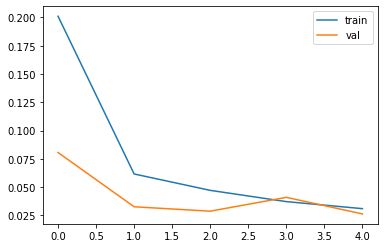

In [22]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [23]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [34]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the Opener?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':sample['Y_label'].values[0],
            'predict:':predict},index=[i])
        if sample['Y_label'].values[0] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [35]:
all_res = test_model(val_df)
all_res

  0%|          | 0/671 [00:00<?, ?it/s]

,label,predict:,是否全對
414,ZHEJIANG MINGRI HOLDINGS GROUP CO,COx000DLTD,No
314,M K INDUSTRIE,INDUSTRIESx000D710,No
2381,R R KABEL LIMITE,LIMITEDx000DSURVEY,No
3236,KIJOO INDUSTRIAL COLT,COLTDx000DKIM,No
2548,AUTOMOTIVE COMPONENTS LT,LTDx000D1137,No
...,...,...,...
1536,SUPREME PETROCHEM LTD,SUPREME PETROCHEM LTDx000DREFER,No
1951,Ren Tong Industrial Limite,Ren Tong Industrial Limitedx000DRM2601,No
761,CHI BAO CORPORATIO,CORPORATIONx000D6F,No
2115,BANDO INDUSTRIAL CO,COx000D153,No


# claculate acc and jaccard

In [36]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

No     662
Yes      9
Name: 是否全對, dtype: int64

acc: 0.013412816691505217
jaccard_avg_score: 0.3443474558228657
